In [20]:
import pickle
from multiprocessing import Pool
from glob import glob
from collections import Counter
from astropy.utils.data import get_pkg_data_filename
import pyink as pu

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from tqdm import tqdm as tqdm
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from reproject import reproject_interp

---

# Quang Dong Nguyen & Mai Schettino - Data Preprocessing Notebook

# Part 1: Data Preprocessing

In [21]:
emu = glob('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits')
print(len(emu))
print(emu[0])

1
image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits


In [22]:
tab = Table.read('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits').to_pandas()
tab.head(5) # there are 35

,BEAM,NAME,RA,DEC,BMAJ,BMIN,BPA
0,0,b'./image.i.EMU_2115-6',-46.451871,-62.170819,12.190899,10.688850,88.638426
1,1,b'./image.i.EMU_2115-6',-44.525079,-62.230139,12.169599,10.691446,88.309974
2,2,b'./image.i.EMU_2115-6',-42.593279,-62.263139,12.506018,10.809036,-86.132462
3,3,b'./image.i.EMU_2115-6',-40.659321,-62.269739,12.109623,10.679411,87.676195
4,4,b'./image.i.EMU_2115-6',-38.726079,-62.249939,12.458843,10.789674,-86.844433


First, we import the fits image file and store it in the `hdu` variable

In [23]:
filename = get_pkg_data_filename('image.i.EMU_2115-60.SB54944.cont.taylor.0.restored.raw.fits')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
wcs.wcs.specsys = 'TOPOCENT'
#np.nanstd(np.squeeze(hdu.data)) #ignore all NaN 

Set OBSGEO-B to   -26.704100 from OBSGEO-[XYZ].
Set OBSGEO-H to      121.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## Assess raw radio data and visualise the image 

In [ ]:
# the unprocessed data will contain many NaN observations in the data due to unavailable data within the image.
hdu.data

We then plot the a simple image visualisation to show the yet processed hdu data

In [ ]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 15515, 0, 13597])
plt.imshow(np.squeeze(hdu.data), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.title('Raw radio image with nan values')
plt.show()
plt.close()
#hough circle only run on jpeg
#pybdsf runs on fits file

## Preprocess raw radio image and visualise the preprocessed image

From there, creating a radio_preprocessing function in which the process imitates the steps from the `PINK` [preprocessing notebook](https://github.com/tjgalvin/pyink/blob/master/Example_Notebooks/PINK_Preprocessing_Example.ipynb)

In [ ]:
def radio_preprocessing(data, lower): #usually was data, lower = 3
    noise = pu.rms_estimate(data.flatten(), mode='mad', clip_rounds=2)

    img_scale = np.zeros_like(data)
    for i, mask in enumerate(pu.island_segmentation(data, lower*noise)): #usually was data, 3*noise
        if np.sum(mask) <= 5:
            continue
        img_scale[mask] = pu.minmax(np.log10(data[mask]))
    return img_scale.astype(np.float32)

TONIGHT EXPLAIN THE RADIO PREPROCESSING METHODS:


Explain the radio preprocessing process:

In [ ]:
#noise = pu.rms_estimate(hdu.data.flatten(), mode='mad', clip_rounds=2)
#a_test = pu.island_segmentation(hdu.data, 4*noise)

Preprocess the raw radio image data, store and export it into a separated file called `preprocessed_radio.txt` so that we dont have to run the preprocessing step again

In [152]:
#-----STORE PREPROCESSED RADIO VALUES INTO A TEXT FILE-------------------------------
#preprocessed_radio_lower3 = radio_preprocessing(hdu.data, lower = 3)
#I have also tried on other lower threshold for noise reduction, including lower = 3, 4, 5
#but for the next section we will test it on lower 3 first and then we go on lower 4 later when tuning parameter

#import pickle
#file = open('preprocessed_radio_lower3.txt', 'wb')
#pickle.dump(preprocessed_radio_lower3, file)
#file.close()


#----loading filename into variable #image.EMU minus -
import pickle
file = open('preprocessed_radio_lower2.txt', 'rb')
preprocessed_data_lower2 = pickle.load(file)

#import pickle
#file = open('preprocessed_radio_lower3.txt', 'rb')
#preprocessed_data_lower3 = pickle.load(file)
#preprocessed_data_lower3 #whenever the file is corrupted, just load this data into the preprocessed_radio data


#file = open('preprocessed_radio_lower4.txt', 'rb')
#preprocessed_data_lower4 = pickle.load(file)
#preprocessed_data_lower4 #whenever the file is corrupted, just load this data into the preprocessed_radio data


#file = open('preprocessed_radio_lower5.txt', 'rb')
#preprocessed_data_lower5 = pickle.load(file)
#preprocessed_data_lower5 #whenever the file is corrupted, just load this data into the preprocessed_radio data


#---------------------------------------------------------------------


#--------------NO NEED FOR THIS STEP----------------------------------
#embed the preprocessed data into the original glob
#preprocessed_hdu = hdu
#preprocessed_hdu.data = preprocessed_radio
#preprocessed_wcs = WCS(preprocessed_hdu.header)
#preprocessed_wcs.wcs.specsys = 'TOPOCENT'
#---------------------------------------------------------------------


In [1]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 15515, 0, 13597]) #0, 15515, 0, 13597
plt.imshow(np.squeeze(preprocessed_data_lower2), origin='lower') #np.squeeze to lower the NAXIS to 2
plt.savefig('preprocessed_EMU_image_lower2.png', dpi = 500, bbox_inches='tight')

#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.title('preprocessed radio image')
plt.show()
plt.close()
#hough circle only run on jpeg
#pybdsf runs on fits file

NameError: name 'plt' is not defined

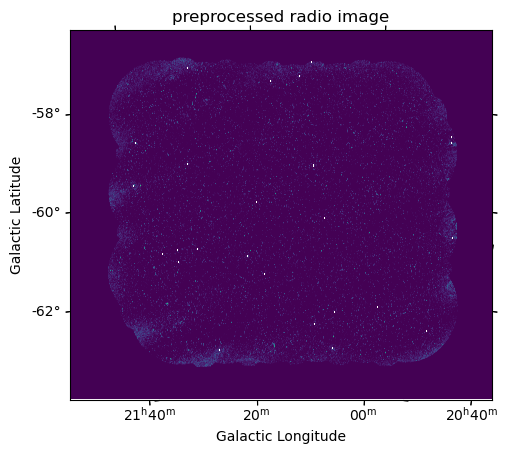

In [117]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 15515, 0, 13597]) #0, 15515, 0, 13597
plt.imshow(np.squeeze(preprocessed_data_lower3), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.savefig('preprocessed_EMU_image_lower3.png', dpi = 500, bbox_inches='tight')

#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.title('preprocessed radio image')
plt.show()
plt.close()
#hough circle only run on jpeg
#pybdsf runs on fits file

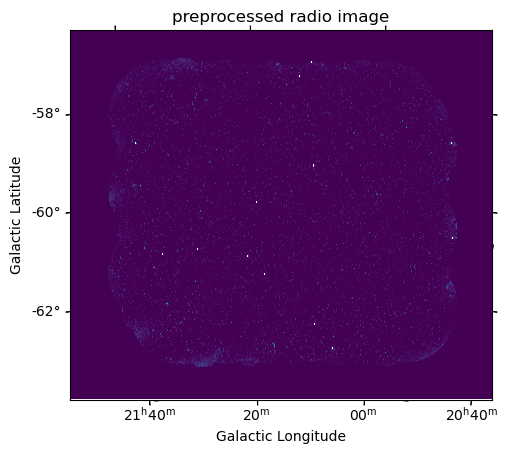

In [118]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 15515, 0, 13597]) #0, 15515, 0, 13597
plt.imshow(np.squeeze(preprocessed_data_lower4), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.savefig('preprocessed_EMU_image_lower4.png', dpi = 500, bbox_inches='tight')

#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.title('preprocessed radio image')
plt.show()
plt.close()
#hough circle only run on jpeg
#pybdsf runs on fits file

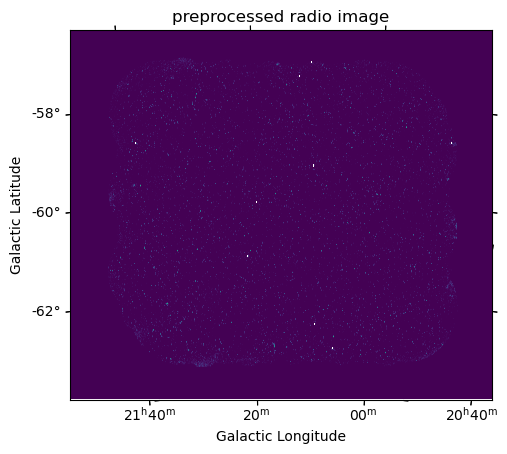

In [119]:
plt.subplot(projection=wcs, slices = ('x','y',0,0))
plt.axis([0, 15515, 0, 13597]) #0, 15515, 0, 13597
plt.imshow(np.squeeze(preprocessed_data_lower5), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.savefig('preprocessed_EMU_image_lower5.png', dpi = 500, bbox_inches='tight')

#plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.title('preprocessed radio image')
plt.show()
plt.close()
#hough circle only run on jpeg
#pybdsf runs on fits file

## Segmentate the preprocessed image into 6 different regions for analysing

**Reason:** Since a whole galaxy image contains a lot of information about the presentations of different stars and galaxies and other celestial objects, we thereby need to divide
the image into smaller regions of images, in which they stores the same information as the original whole galaxy image. Therefore, it would be a lot easier for the next step which
is creating object detection algorithms, where we can use these algorithms to detect small ORCS on the sky without having to scan through an entire region of the sky.


Before dividing into regions, we need to trim empty spaces of the image through manual estimating of the physical coordinate of the image corners. As it can be seen above, the image is not a flat square image but rather a file with different blocks circles of regions that binds together to form a completely scanned image of the sky region, so we need to trim the empty space outside these circles that are filled with empty space:
- left: 1420 for x (trim it) right: 14234 for x (trim it)
- up : 12551 for y (trim it) bottom: 1185 for y (trim it)
- The limited x-range is now from 4654 to 9083, in which the length is 12814
- The limited y-range is now from 1185 to 12551, in which the length is 11366

using `np.linspace()` we estimate the regions as follows:
```
np.linspace(1420, 14234, 3 + 1)
np.linspace(1185, 12551, 2 + 1)
```

- The first image has the image length from 1420 to 5691 and width of 1185 to 6868
- The second image has the image length from 5692 to 9962 and width of 1185 to 6868
- The third image has the image length from 9963 to 14234 and width of 1185 to 6868
- The fouth image has the x-coordination from 1420 to 5691 and y-coordination from 6869 to 12551
- The fifth image has the x-coordination from 5692 to 9962 and y-coordination from 6869 to 12551
- The sixth image has the x-coordination from 9963 to 14234 and y-coordination from 6869 to 12551

In [154]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower2), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    plt.savefig(f'region{i+1}preprocessed_EMU_image_lower2.png', dpi = 500, bbox_inches='tight')
    plt.close()

In [ ]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower3), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    #plt.savefig(f'region{i+1}preprocessed_EMU_image_lower3.png', dpi = 500, bbox_inches='tight')
    plt.close()

In [ ]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower4), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    #plt.savefig(f'region{i+1}preprocessed_EMU_image_lower4.png', dpi = 500, bbox_inches='tight')
    plt.close()

In [ ]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower5), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    #plt.savefig(f'region{i+1}preprocessed_EMU_image_lower5.png', dpi = 500, bbox_inches='tight')
    plt.close()

---

# EXAMPLE: Testing radio preprocessing steps the  with the ASKAP's image of ORCS circle

In [136]:
from astropy.io import fits
 
with fits.open('orc1-askap.fits') as hdu_test:
    askap_orc_data = hdu_test[0].data
    askap_header = hdu_test[0].header
    askap_wcs = WCS(askap_header)

In [121]:
plt.subplot(projection=askap_wcs, slices = ('x','y',0,0))
plt.imshow(np.squeeze(askap_orc_data), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.title("ASKAP's Image of Orcs")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.close()
#hough circle only run on jpeg
#pybdsf runs on fits file

Running the preprocessing steps on the ASKAP's sample image of ORCs, and then visualise it

In [122]:
#------------------RADIO PREPROCESSING-------------------------------------
preprocessed_radio_ORCS = radio_preprocessing(askap_orc_data, lower = 3)
#--------------------------------------------------------------------------

plt.subplot(projection=askap_wcs, slices = ('x','y',0,0))
plt.imshow(np.squeeze(preprocessed_radio_ORCS), origin='lower') #np.squeeze to lower the NAXIS to 2
#plt.grid(color='white', ls='solid')
plt.axis('off')
#plt.savefig('ASKAP_ORCS.jpg', dpi = 500, bbox_inches='tight')
plt.title("ASKAP's Image of Orcs")
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.close()
#hough circle only run on jpeg
#pybdsf runs on fits file

---

# Part 2: Classification task

## Oject Detection Algorithm 1: Circle Hough Transform - OpenCV

### ASKAP's Sample Image of ORCS

First we will test the Circle Hough Transform algorithm on the ASKAP's sample image of ORCs

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

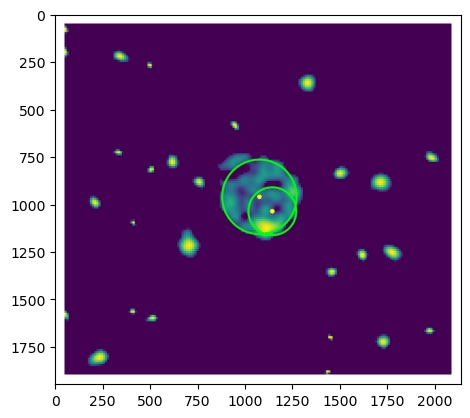

In [124]:
img = cv.imread('ASKAP_ORCS.jpg')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)

circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, 1, 100, 
                          param1=50, param2=30, minRadius=100, maxRadius=200)


if circles is not None:
    detected_circles = np.uint16(np.around(circles))
    for (x, y, r) in detected_circles[0, :]:
        cv.circle(output, (x, y), r, (0, 255, 0), 10)
        cv.circle(output, (x, y), 2, (0, 255, 255), 20)

else:
    print("No circles were detected. Try adjusting the parameters.")

# Display the image with detected circles
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.show()
plt.close()

### EMU Image: Testing on the 3rd region of the EMU image

Since the third region of the EMU image contains the appearance of an ORC, we will use the Circle Hough Transform with modified parameters to check whether the algorithm can detect the ORC's appearance within the image.

Hough Circle Parameter explains, `cv.HoughCircles()`:
- inputArray: `gray` (gray is the image after the conversion from Colour to grayscale)
- circles: `cv.HOUGH_GRADIENT` (a variant of the circle detection methods, there are other methods i.e. `HOUGH_STANDARD`, `HOUGH_PROBABILISTIC`, etc). I chose this method since it is the standard way for detection of circles
- dp: `1.5` (with dp of 1, the accumulator, hwich used to detect shapes like circles in an image, has the same size as the input image, but with dp of 2, the accumulator is smaller with half the width and height of the input image. Since in this setting where we detect very small circles, a value of 1.5 dp is suitable (recommended by OpenCV).
- minDist: `500` (minDist tells the minimum distance required between the centers of the detected circles, if the parameter has lower number, multiple neighbor circles may be falsely detected and if the number is too big, some circles might be missed. Therefore, I put 500 pixels as the threshold to detect for the minDist between circles. However, again, as we learnt in the region 6 of the image, it contains 2 pre-determined ORCS and they are next to each other in a very close pixel regions, so with this minDist of 500, it cannot detect two ORCs at once, hence, we are then further required to classify the appearance of those ORCS mannually in these circumstances.
- param1: `300` (in the case of `cv.HOUGH_GRADIENT`, it is the higher threshold of the two passed to the [Canny Edge detector] (https://ieeexplore.ieee.org/document/4767851) (the lower one is twice smaller). Canny Edge Detector is simple detector using operators of several wdiths to cope with different signal-to-noise ratios in the image.
- param2: `10` in case of `cv.HOUGH_GRADIENT`, it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. 

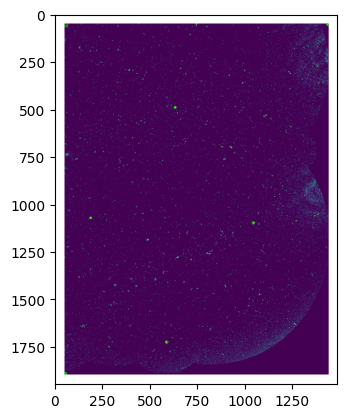

In [43]:
img = cv.imread('region6preprocessed_EMU_image_lower3.png')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)
circles = cv.HoughCircles(gray, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          500, 
                          param1=300, param2=10, 
                          minRadius=5, 
                          maxRadius=10)

if circles is not None:
    detected_circles = np.uint16(np.around(circles))
    for (x, y, r) in detected_circles[0, :]:
        cv.circle(output, (x, y), r, (0, 255, 0), 2)  # Circle outline
        cv.circle(output, (x, y), 1, (0, 255, 255), 2)  # Circle center
else:
    print("No circles were detected. Try adjusting the parameters.")

# Display the image with detected circles
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.savefig('output_testing', dpi=500)
plt.show()
plt.close()

### EMU Image: Testing on the 6th region of the EMU image

Similarly, the 6th region contains the appearance of an ORC that we are trying to detect, with the same model and parameters, we are trying to detect the ORC through the hough transform package.


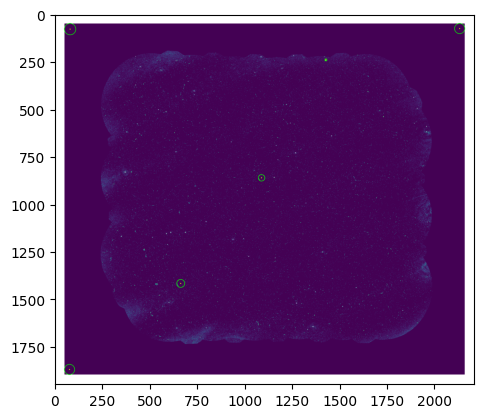

In [17]:
img = cv.imread('preprocessed_EMU_image_lower3.png')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)
circles = cv.HoughCircles(gray, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          500, 
                          param1=300, param2=10, 
                          minRadius=5, 
                          maxRadius=40)

if circles is not None:
    detected_circles = np.uint16(np.around(circles))
    for (x, y, r) in detected_circles[0, :]:
        cv.circle(output, (x, y), r, (0, 255, 0), 2)  # Circle outline
        cv.circle(output, (x, y), 1, (0, 255, 255), 2)  # Circle center

else:
    print("No circles were detected. Try adjusting the parameters.")

# Display the image with detected circles
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.savefig('output_testing', dpi=500)
plt.show()
plt.close()

## Object Detection Algorithm 2: SimpleBlob Detector - OpenCV

### EMU Image: Testing on the 3rd region of the EMU image

The second algorithm provides more options to detect blob of celestial objects on the sky than the Circle Hough Transform algorithm, it provides options to change `thresholds`, `area`, `convexity`, etc, we twist the parameter however it suits the properties of a ORC circle.

OpenCV SimpleBlob Detector parameter explains:
Current Parameters
- minthreshold = 10, max = 200
- minArea = 5, max = 40
- filterByInertia = 0

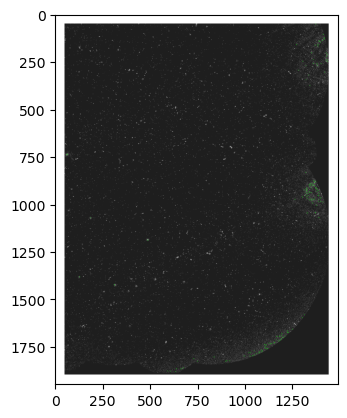

In [142]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

#Read Image
im = cv2.imread("region3preprocessed_EMU_image_lower3.png", cv2.IMREAD_GRAYSCALE)

if im is None:
    print("Error: Could not load the image.")
else:
    #Setup SimpleBlobDetector_create parameters
    params = cv2.SimpleBlobDetector_Params()

    #filter by thresholdes
    params.minThreshold = 20
    params.maxThreshold = 150
    
    #Filter by Area
    params.filterByArea = 1
    params.minArea = 2
    params.maxArea = math.pi * 10**2

    #filter by Circularity
    
    #Filter by inertia
    params.filterByInertia = 1
    params.minInertiaRatio = 0.2
    params.maxInertiaRatio = 0.9

    #Convexity
    #params.filterByConvexity = 1
    #params.minConvexity = 0.5
    #params.maxConvexity = 0.7
    
    # Set up the blob detector with default parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0])<3:
        detector = cv2.SimpleBlobDetector(params)
    else:
        detector = cv2.SimpleBlobDetector_create(params)

    #Detect Blobs:
    keypoints = detector.detect(im)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#shows image:
plt.imshow(cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2RGB))
plt.savefig('output_testing_simpleBlob', dpi=500)
plt.show()
plt.close()

### Testing on the 6th region of the EMU image

In [18]:
import math
math.pi * 10**2 

314.1592653589793

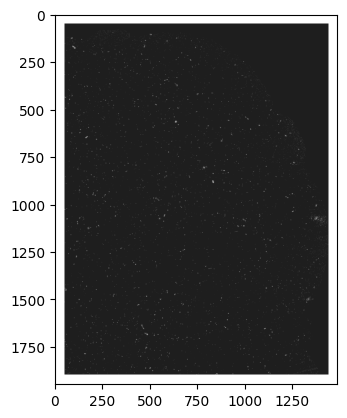

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Read Image
im = cv2.imread("region6preprocessed_EMU_image.png", cv2.IMREAD_GRAYSCALE)

if im is None:
    print("Error: Could not load the image.")
else:
    #Setup SimpleBlobDetector_create parameters
    params = cv2.SimpleBlobDetector_Params()

    #filter by thresholdes
    params.minThreshold = 20
    params.maxThreshold = 150
    
    #Filter by Area
    params.filterByArea = 1
    params.minArea = 2
    params.maxArea = math.pi * 40**2

    #filter by Circularity
    
    #Filter by inertia
    params.filterByInertia = 1
    params.minInertiaRatio = 0.2
    params.maxInertiaRatio = 0.9

    #Convexity
    #params.filterByConvexity = 1
    #params.minConvexity = 0.5
    #params.maxConvexity = 0.7
    
    # Set up the blob detector with default parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0])<3:
        detector = cv2.SimpleBlobDetector(params)
    else:
        detector = cv2.SimpleBlobDetector_create(params)

    #Detect Blobs:
    keypoints = detector.detect(im)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#shows image:
plt.imshow(cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2RGB))
plt.savefig('output_testing_simpleBlob', dpi=500)
plt.show()

## Object Detection Algorithm 3: PyBDFS

---

# Testing on preprocessed image.i.EMU_1315+00B.SB64249.cont.taylor.0.restored.raw.fits

In [129]:
#--loading filename into variable #image.EMU plus +
import pickle
file = open('preprocessed_radio_lower2plus.txt', 'rb')
preprocessed_data_lower2plus = pickle.load(file)
#preprocessed_data_lower2plus #whenever the file is corrupted, just load this data into the preprocessed_radio data

import pickle
file = open('preprocessed_radio_lower3plus.txt', 'rb')
preprocessed_data_lower3plus = pickle.load(file)
#preprocessed_data_lower3plus #whenever the file is corrupted, just load this data into the preprocessed_radio data

import pickle
file = open('preprocessed_radio_lower4plus.txt', 'rb')
preprocessed_data_lower4plus = pickle.load(file)
#preprocessed_data_lower4plus #whenever the file is corrupted, just load this data into the preprocessed_radio data

import pickle
file = open('preprocessed_radio_lower5plus.txt', 'rb')
preprocessed_data_lower5plus = pickle.load(file)
#preprocessed_data_lower5plus #whenever the file is corrupted, just load this data into the preprocessed_radio data


In [ ]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower2plus), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    #plt.savefig(f'region{i+1}preprocessed_EMU_image_lower2plus.png', dpi = 500, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower3plus), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    #plt.savefig(f'region{i+1}preprocessed_EMU_image_lower3plus.png', dpi = 500, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower4plus), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    #plt.savefig(f'region{i+1}preprocessed_EMU_image_lower4plus.png', dpi = 500, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
# Define the coordinates for the 6 regions
regions = [
    (1420,5691,1185,6868),  # Region 1
    (5692,9962,1185,6868),  # Region 2
    (9963,14234,1185,6868),  # Region 3
    (1420,5691,6869,12551), # Region 4
    (5692,9962,6869,12551), # Region 5
    (9963,14234,6869,12551)  # Region 6
]

for i,region in enumerate(regions):
    plt.subplot(projection=wcs, slices = ('x','y',0,0))
    plt.axis(region)
    plt.imshow(np.squeeze(preprocessed_data_lower5plus), origin='lower') #np.squeeze to lower the NAXIS to 2
    plt.axis('off')
    #plt.savefig(f'region{i+1}preprocessed_EMU_image_lower5plus.png', dpi = 500, bbox_inches='tight')
    plt.show()
    plt.close()

## Object Detection Algorithm 1: Circle Hough Transform - OpenCV

### Emu Image Plus: Testing on the 6 regions of the image using HoughCircles Methods

In [ ]:
img = cv.imread('region6preprocessed_EMU_image_lower2plus.png')
output = img.copy()
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)
circles = cv.HoughCircles(gray, 
                          cv.HOUGH_GRADIENT, 
                          1.5, 
                          500, 
                          param1=300, param2=10, 
                          minRadius=5, 
                          maxRadius=40)

if circles is not None:
    detected_circles = np.uint16(np.around(circles))
    for (x, y, r) in detected_circles[0, :]:
        cv.circle(output, (x, y), r, (0, 255, 0), 2)  # Circle outline
        cv.circle(output, (x, y), 1, (0, 255, 255), 2)  # Circle center
else:
    print("No circles were detected. Try adjusting the parameters.")


# Display the image with detected circles
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.savefig('output_testing', dpi=500)
plt.show()
plt.close()

### Emu Image Plus: Testing on the 6 regions of the image using SimpleBloBDetector - OpenCV method

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Read Image
im = cv2.imread("region6preprocessed_EMU_image_lower2plus.png", cv2.IMREAD_GRAYSCALE)

if im is None:
    print("Error: Could not load the image.")
else:
    #Setup SimpleBlobDetector_create parameters
    params = cv2.SimpleBlobDetector_Params()

    #filter by thresholdes
    params.minThreshold = 20
    params.maxThreshold = 150
    
    #Filter by Area
    params.filterByArea = 1
    params.minArea = 2
    params.maxArea = math.pi * 10**2

    #filter by Circularity
    #params.filterByCircularity = 1
    #params.minCircularity = 0.1
    #params.maxCircularity = 0.9
    
    #Filter by inertia
    params.filterByInertia = 1
    params.minInertiaRatio = 0.2
    params.maxInertiaRatio = 0.9

    #Convexity
    #params.filterByConvexity = 1
    #params.minConvexity = 0.5
    #params.maxConvexity = 0.7
    
    # Set up the blob detector with default parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0])<3:
        detector = cv2.SimpleBlobDetector(params)
    else:
        detector = cv2.SimpleBlobDetector_create(params)

    #Detect Blobs:
    keypoints = detector.detect(im)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#shows image:
plt.imshow(cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2RGB))
plt.savefig('output_testing_simpleBlob', dpi=500)
plt.show()
plt.close()

# REFERENCE

- https://academic.oup.com/mnras/article/513/1/1300/6553851?login=false from this research site: https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.1300N/graphics
- https://scikit-image.org/docs/stable/auto_examples/edges/plot_circular_elliptical_hough_transform.html
- https://learn.astropy.org/tutorials/2-Coordinates-Transforms
- https://learnopencv.com/blob-detection-using-opencv-python-c/